# JSON Loader + Content Explorer

## TODO:
- Compare plots for different binning levels and for different material generations (homogeneity)

## Imports

In [1]:
import json
import uproot
import numpy as np
from scipy import stats
from importlib import reload
from functools import reduce
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def jsl(fn):
    x = []
    with open(fn,'r') as f:
        x = json.load(f)
    return x

def jss(d, f):
    with open(f,'w') as file:
        json.dump(d, file, sort_keys=True, indent=4, separators=(',', ': '))

## Load data

In [2]:
gen_mat = jsl('generic-material.json')
proto_layer_mat = jsl('proto-layer-material.json')
mapped_binned = jsl('mapped-binned.json')
mapped_binned_proto = jsl('mapped-binned-proto.json')
mapped_binned_proto_20 = jsl('mapped-binned-proto-20.json')
mapped_binned_proto_40 = jsl('mapped-binned-proto-40.json')

def json_tree(j):
    try:
        print(j.keys())
        json_tree(j[list(j.keys())[0]])
    except AttributeError:
        return

## View hierarchy (children) of each leftmost branch to compare structure
Most important is the last entry (bin0, bin1, data, type)

In [3]:
print("Generic Material")
json_tree(gen_mat)
print("\nProto Layer Material")
json_tree(proto_layer_mat)
print("\nMapped Binned")
json_tree(mapped_binned)
print("\nMapped Binned Proto")
json_tree(mapped_binned_proto)

Generic Material
dict_keys(['volumes'])
dict_keys(['10', '12', '13', '14', '16', '17', '18', '5', '7', '8', '9'])
dict_keys(['layers', 'name'])
dict_keys(['2'])
dict_keys(['representing'])
dict_keys(['data', 'type'])

Proto Layer Material
dict_keys(['volumes'])
dict_keys(['10', '12', '13', '14', '16', '17', '18', '5', '7', '8', '9'])
dict_keys(['layers', 'name'])
dict_keys(['2'])
dict_keys(['representing'])
dict_keys(['bin0', 'bin1', 'type'])

Mapped Binned
dict_keys(['volumes'])
dict_keys(['10', '12', '13', '14', '16', '17', '18', '5', '7', '8', '9'])
dict_keys(['layers', 'name'])
dict_keys(['2'])
dict_keys(['representing'])
dict_keys(['data', 'type'])

Mapped Binned Proto
dict_keys(['volumes'])
dict_keys(['10', '12', '13', '14', '16', '17', '18', '5', '7', '8', '9'])
dict_keys(['layers', 'name'])
dict_keys(['2'])
dict_keys(['representing'])
dict_keys(['bin0', 'bin1', 'data', 'type'])


## Some exploratory analysis

In [7]:
def flatten(list_to_flatten):
    for elem in list_to_flatten:
        if isinstance(elem,(list, tuple)):
            for x in flatten(elem):
                yield x
        else:
            yield elem
            
def recursive_search(j, key):
    try:
        if key in j.keys():
            return j[key]
        else:
            found = []
            for k in j.keys():
                found.append(recursive_search(j[k], key))
            return found
    except:
        return []
        
set(flatten(recursive_search(gen_mat, 'type'))) # try 'data' and 'type'

{'homogeneous'}

## Understanding $\phi$ and $\theta$ 

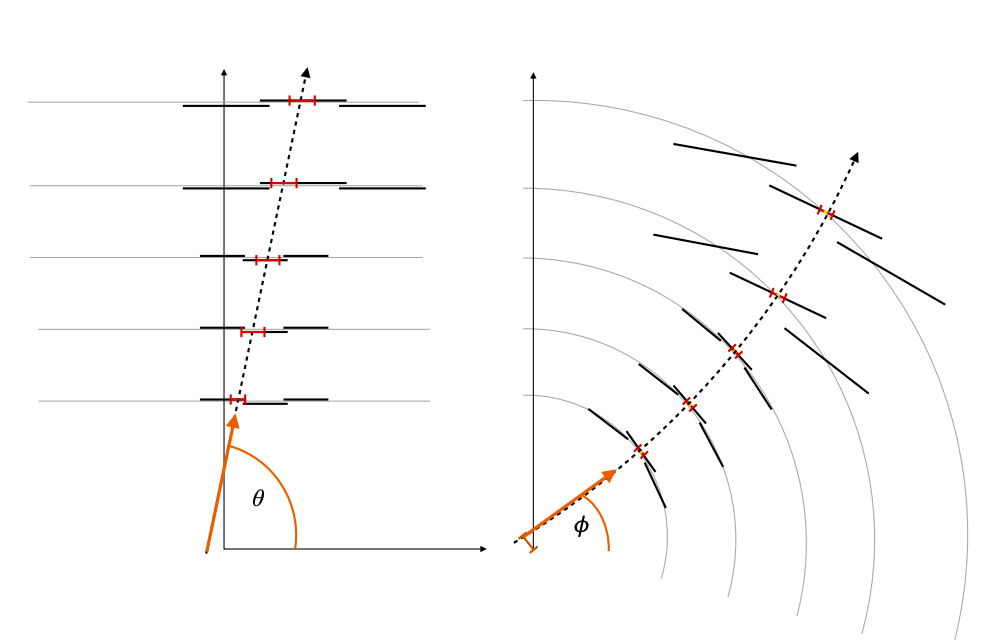

## Proto Data

binR, binZ, binPhi

open, closed

In [11]:
print(len(proto_layer_mat['volumes']['12']['layers'].keys())) # sstrip negative endcap layers
print(len(proto_layer_mat['volumes']['14']['layers'].keys())) # sstrip positive endcap layers

13
13


In [12]:
check_vols = lambda f,d: all(f(d['volumes'][v]) for v in d['volumes'])
check_layers = lambda f,v: all(f(v['layers'][l]) for l in v['layers'])

def layer_type_reduce(v):
    layers = v['layers']
    comp = list(layers[list(layers.keys())[0]].keys())[0]
    return all(list(layers[l].keys())[0] == comp for l in layers)

def layer_full_reduce(v):
    layers = v['layers']
    comp = list(layers[list(layers.keys())[0]].keys())[0]
    
    checklist = [set(layers[l][comp].keys()) for l in layers]
    check = reduce(lambda x,y: x and y[0]==y[1], [True]+list(zip(checklist[:-1], checklist[1:])))
    
    all_keys = {'randomStringForSetDifference'}
    if check:
        all_keys = reduce(lambda x,y: x.union(y), [set(layers[l][comp].keys()) for l in layers])
    return len(all_keys-set(layers[list(layers.keys())[0]][comp].keys())) == 0

proto_layer_mat['volumes']['12']['layers']['1']['representing']

{'bin0': ['binR', 'open', 10],
 'bin1': ['binPhi', 'closed', 10],
 'type': 'proto'}

## Check that all layers are of the same type ("representing", "approach", ...) in each volume.
## Check that all layers contain the same keys (bin0, bin1, type)

In [13]:
print(check_vols(layer_type_reduce, proto_layer_mat))
print(check_vols(layer_full_reduce, proto_layer_mat))

True
True


# Command Descriptions

```sh
./ACTFWGenericMaterialValidationExample 
    -n1000 
    --output-root on
mv propagation-material.root propagation-material-input.root
```
**Purpose:** Generate particle tracks from predefined (pre-coded) material input

**End Result:** `propagation-material-input.root` containing particle tracks (**material tracks?**)

---
```sh
./ACTFWGenericGeometryExample 
    --mat-output-file generic-material 
    --output-json on
```
**Purpose:** Generate a material `.json` file.

**End Result:** `generic-material.json` containing material description

---
```sh
./ACTFWGenericMaterialValidationExample 
    -n100 
    --mat-input-type file 
    --mat-input-file generic-material.json 
    --output-root on
mv propagation-material.root propagation-material-from-map.root
```
**Purpose:** To compare built material input vs json input

**End Result:** `propagation-material-from-map.root` containing particle tracks

---
```sh
./ACTFWGenericGeometryExample 
    --mat-input-type proto 
    --mat-output-file proto-layer-material 
    --mat-output-sensitives off 
    --mat-output-data off 
    --output-json on
    -n1
```
**Purpose:** Create proto-maps where sensitives are excluded (map only onto layer surfaces)

**End Result:** `proto-layer-material.json` containing proto-map

---
```sh
./ACTFWGenericMaterialMappingExample 
    -n 1000000  
    --mat-input-type file 
    --mat-input-file proto-layer-material.json 
    --mat-output-file mapped-binned-proto 
    --output-json on 
    --input-root on 
    --input-files propagation-material-input.root 
    -j1
```
**Purpose:** Mapping onto proto maps

**End Result:** `mapped-binned-proto.json`

---
```sh
./ACTFWGenericMaterialMappingExample 
    -n 1000000  
    --mat-input-type file 
    --mat-input-file generic-material.json 
    --mat-output-file mapped-binned
    --output-json on 
    --input-root on 
    --input-files propagation-material-input.root 
    -j1
```
**Purpose:** Mapping onto same structure (including sensitives)

**End Result:** `mapped-binned.json`

In [14]:
gen_mat['volumes']['10']['layers']['2']['representing']['data']#.keys()

[[[352.79998779296875,
   407.0,
   4.0,
   9.01200008392334,
   0.0018479999853298068,
   1.7999999523162842]]]

In [15]:
def rec_join(subtree):
    while [] in subtree:
        subtree.remove([])
#     print("st",subtree)
    return subtree

def rec_fix(subtree):
    if [] in subtree:
        subtree.remove([])
#     print("Subtree:", subtree)
    if len(subtree)>1 and [] in subtree[1]:
        subtree[1].remove([])
        
    # subbranch join
    
    return subtree
    
def json_recurse(j):
    c = []
    try:
        c = list(j.keys())
        c += rec_join([json_recurse(j[k]) for k in j])
    
        return c
    except AttributeError:
        return c
    
    
x0 = json_recurse(gen_mat)

# Root file exploration

In [16]:
file1 = uproot.open("propagation-material-input.root")
file2 = uproot.open("propagation-material-from-map.root")

data = file1['material-tracks;14'].arrays(['*'])
data_from_map = file2['material-tracks;2'].arrays(['*'])

print(file1.keys(), file2.keys())
file1['material-tracks;13'].show()
print(file1['material-tracks;14'].array('v_x').shape,file1['material-tracks;13'].array('v_x').shape)
print(file2['material-tracks;2'].array('v_x').shape,file2['material-tracks;1'].array('v_x').shape)
print("POSSIBLE ISSUE WITH -n100 in cmd3")

[b'material-tracks;14', b'material-tracks;13'] [b'material-tracks;2', b'material-tracks;1']
v_x                        (no streamer)              asdtype('>f4')
v_y                        (no streamer)              asdtype('>f4')
v_z                        (no streamer)              asdtype('>f4')
v_px                       (no streamer)              asdtype('>f4')
v_py                       (no streamer)              asdtype('>f4')
v_pz                       (no streamer)              asdtype('>f4')
v_phi                      (no streamer)              asdtype('>f4')
v_eta                      (no streamer)              asdtype('>f4')
t_X0                       (no streamer)              asdtype('>f4')
t_L0                       (no streamer)              asdtype('>f4')
mat_x                      TStreamerSTL               asjagged(asdtype('>f4'), 10)
mat_y                      TStreamerSTL               asjagged(asdtype('>f4'), 10)
mat_z                      TStreamerSTL             

## Explore the distribution of different attributes from each track (initial conditions)

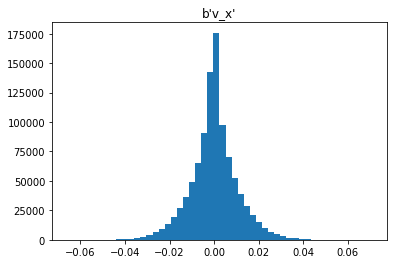

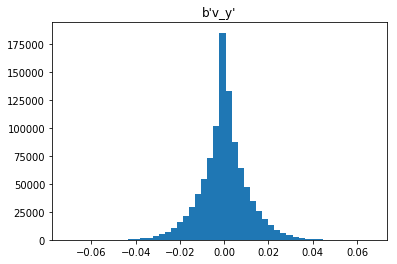

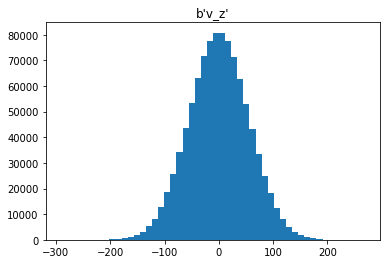

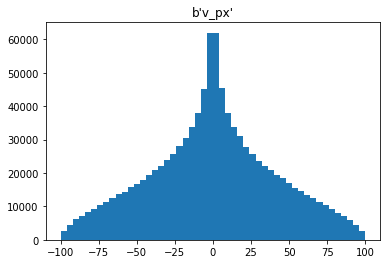

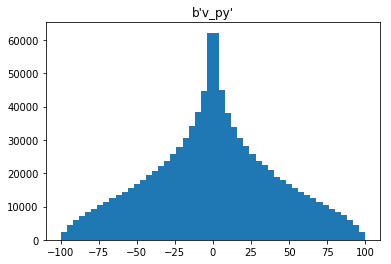

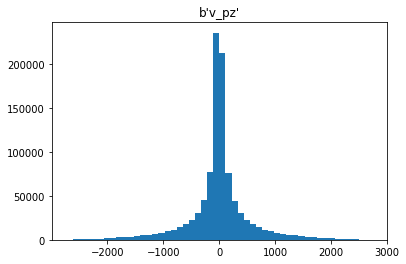

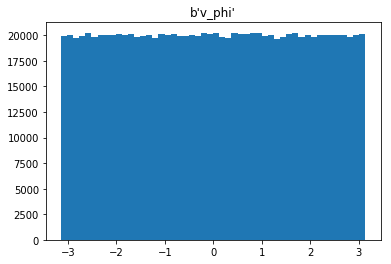

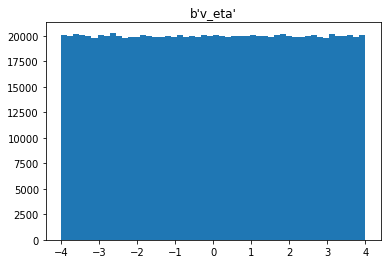

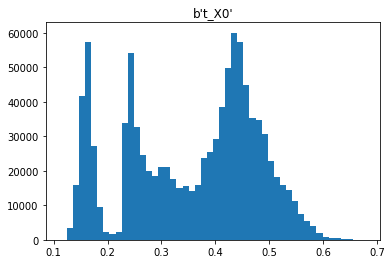

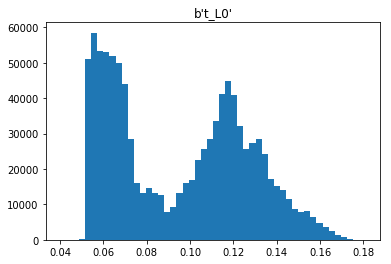

In [18]:
%matplotlib inline

for k in [b'v_x', b'v_y', b'v_z', b'v_px', b'v_py', b'v_pz', b'v_phi', b'v_eta', b't_X0', b't_L0']:
    plt.hist(data[k],50)
    plt.title(str(k))
    plt.show()

## Plot some of the tracks

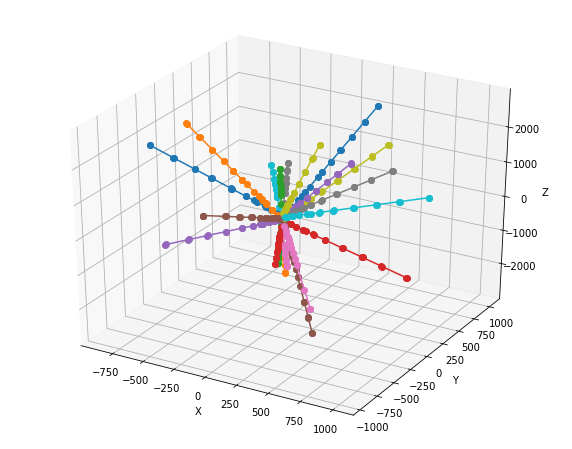

In [19]:
reload(plt)
%matplotlib inline

# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(data[b'v_x'], data[b'v_y'], data[b'v_z'])
# plt.show()

# plt.hist(data[b'mat_x'],1)
# plt.show()

i = range(20)
x, y, z, ds = data[b'mat_x'][i], data[b'mat_y'][i], data[b'mat_z'][i], data[b'mat_step_length'][i]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
for track in range(len(i)):
    ax.plot(x[track],y[track],z[track], 'o-')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

## Some more exploratory analysis and checks

In [20]:
data[b'v_x'][i], data[b'v_y'][i], data[b'v_z'][i]

for k in data:
    try:
        print(str(k), len(data[k][0]))
    except:
        print(str(k), 1)

b'v_x' 1
b'v_y' 1
b'v_z' 1
b'v_px' 1
b'v_py' 1
b'v_pz' 1
b'v_phi' 1
b'v_eta' 1
b't_X0' 1
b't_L0' 1
b'mat_x' 23
b'mat_y' 23
b'mat_z' 23
b'mat_step_length' 23
b'mat_X0' 23
b'mat_L0' 23
b'mat_A' 23
b'mat_Z' 23
b'mat_rho' 23


In [21]:
print(data[b'mat_step_length'].sum()[0])

def euclidian_distance(d):
    s = 0
    for axis in [b'mat_x', b'mat_y', b'mat_z']:
        s += (d[axis][0][0] - d[axis][0][-1])**2
    return s**(0.5)


# (data[b'mat_x'][0][0]-data[b'mat_x'][0][-1])**2

euclidian_distance(data) # non linear paths ? -> seem to be linear in track plot

46.147686


1918.9136052491326

In [22]:
data[b'mat_step_length'][0]

array([1.6918224 , 0.3172196 , 3.1721659 , 0.31861845, 3.1721659 ,
       0.31885415, 3.1721656 , 0.32141498, 3.1721656 , 3.8065987 ,
       4.229554  , 0.5312425 , 4.229554  , 0.5312425 , 0.5405914 ,
       4.229554  , 0.53306836, 0.28372467, 2.8372467 , 0.39721453,
       3.9721453 , 3.9721453 , 0.39721453], dtype=float32)

In [23]:
print(data[b'mat_step_length'][0][:2].sum())

def euclidian_distance(d):
    s = 0
    for axis in [b'mat_x', b'mat_y', b'mat_z']:
        s += (d[axis][0][0] - d[axis][0][1])**2
    return s**(0.5)


# (data[b'mat_x'][0][0]-data[b'mat_x'][0][-1])**2

euclidian_distance(data) # mat_step_length => length spent in material

2.009042


27.354321937684606

## Symbol List

|Symbol|Definition|
|---|---|
|v_|initial conditions|
|p|momentum|
|eta|pseudorapidity (angle along beam line - z)|
|X0|radiation length|
|L0|__ length|
|A|mass number|
|Z|atomic number|
|rho|density|
|mat_step_length|step size in material|

## Plot the detector material

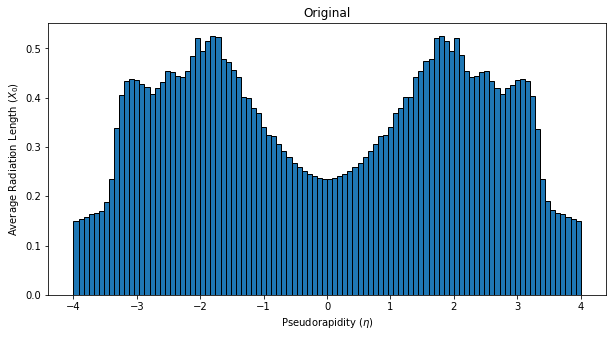

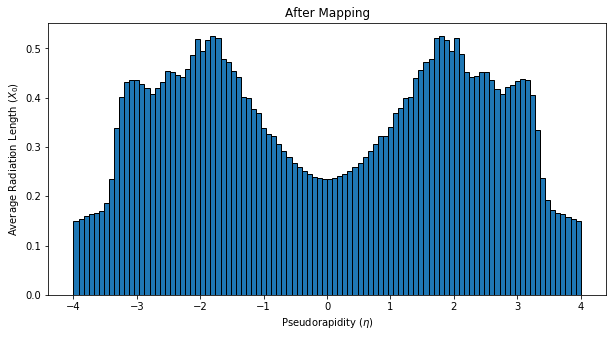

In [48]:
%matplotlib inline

h = stats.binned_statistic(data[b'v_eta'], data[b't_X0'], 'mean', bins=100)
h_centres = list(map(lambda x: sum(x)/2, zip(h.bin_edges[:-1],h.bin_edges[1:])))

plt.figure(figsize=(10,5))
plt.bar(h_centres, h.statistic, linewidth=1, edgecolor='k', width=0.08)
plt.xlabel(r"Pseudorapidity ($\eta$)")
plt.ylabel(r"Average Radiation Length ($X_0$)")
plt.title("Original")
plt.show()

h = stats.binned_statistic(data_from_map[b'v_eta'], data_from_map[b't_X0'], 'mean', bins=100)
h_centres = list(map(lambda x: sum(x)/2, zip(h.bin_edges[:-1],h.bin_edges[1:])))

plt.figure(figsize=(10,5))
plt.bar(h_centres, h.statistic, linewidth=1, edgecolor='k', width=0.08)
plt.xlabel(r"Pseudorapidity ($\eta$)")
plt.ylabel(r"Average Radiation Length ($X_0$)")
plt.title("After Mapping")
plt.show()

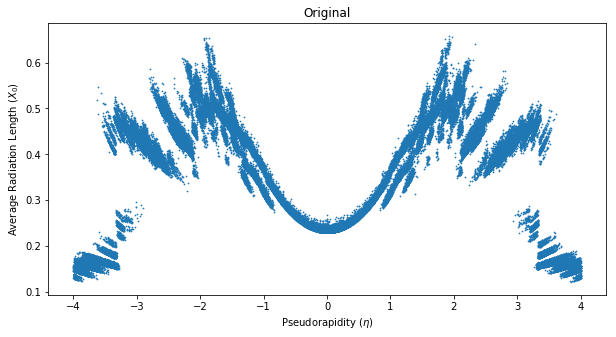

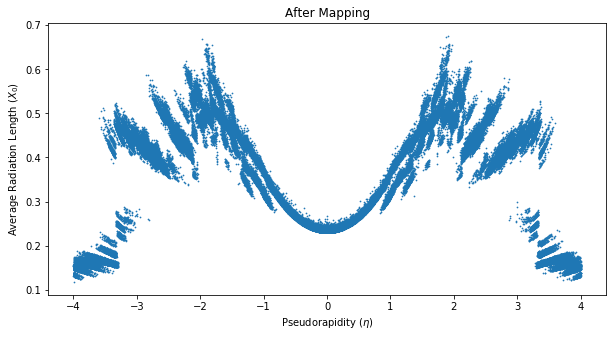

In [49]:
plt.figure(figsize=(10,5))
plt.scatter(data[b'v_eta'][::10], data[b't_X0'][::10], s=0.5)
plt.xlabel(r"Pseudorapidity ($\eta$)")
plt.ylabel(r"Average Radiation Length ($X_0$)")
plt.title("Original")
plt.savefig("3.pdf")
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(data_from_map[b'v_eta'], data_from_map[b't_X0'], s=0.5)
plt.xlabel(r"Pseudorapidity ($\eta$)")
plt.ylabel(r"Average Radiation Length ($X_0$)")
plt.title("After Mapping")
plt.savefig("4.pdf")
plt.show()

## Some more json convenience functions

In [33]:
# json data extractor
def jpath(d):
    if not isinstance(d, str):
        if 'data' in d.keys():
            return d['data']
        else:
            child_paths = [jpath(d[i]) for i in d]
            return child_paths
        
# json data leave nodes counter
def jdcnt(d):
    if not isinstance(d, str):
        if 'data' in d.keys():
            return 1
        else:
            return sum([jdcnt(d[i]) for i in d])
    return 0

# json path leave nodes counter
def jpcnt(d):
    if isinstance(d, (list,np.ndarray)):
        if isinstance(d[0], (int,float)):
            return 1
        else:
            return sum([jpcnt(d[a]) for a in range(len(d))])
    return 0

jp = np.array(jpath(gen_mat))
jpcnt(jp), jdcnt(gen_mat)

(18822, 18822)

In [34]:
def jconcise(d):
    ret = {}
    vs = d['volumes']
    for v in vs:
        ls = vs[v]['layers']
        ret[int(v)] = {}
        for l in ls:
            ret[int(v)][int(l)] = {}
            for t in ls[l]:
                ret[int(v)][int(l)][t] = []
                if t == 'representing':
                    ret[int(v)][int(l)][t] = ls[l][t]['data']
                else:
                    entry = {}
                    for data in ls[l][t]:
                        entry[data] = ls[l][t][data]['data']
                    ret[int(v)][int(l)][t].append(entry)
                        
                
    return ret

jc = jconcise(gen_mat) # volumes, layers, representing / sensitive / approach, data

In [35]:
# jc[10][2]['representing']

# keys_dict = {
#     0: '0',
#     1: '1',
#     2: '2',
#     3: '3',
#     4: '4',
#     5: '5',
# }


# def layer_plot(data, volume, layer, key=0):
#     print("Plotting for volume {}, layer {}".format(volume, layer))
#     ss = data[volume][layer]
    
#     plt.figure(figsize=(15,3))
    
#     if 'representing' in ss:
#         plt.subplot(131)
#         plt.hist(ss['representing'][0][0][key])
#         plt.title('representing')
#         plt.xlabel(keys_dict[key])
        
#     if 'sensitive' in ss:
#         sendata = []
#         for sl in ss['sensitive']:
#             for k in sl:
#                 sendata.append(sl[k][0][0][key])
#         plt.subplot(132)
#         plt.hist(sendata)
#         plt.title('sensitive')
#         plt.xlabel(keys_dict[key])
    
#     if 'approach' in ss:
#         appdata = []
#         for sl in ss['approach']:
#             for k in sl:
#                 appdata.append(sl[k][0][0][key])
                
#         plt.subplot(133)
#         plt.hist(appdata)
#         plt.title('approach')
#         plt.xlabel(keys_dict[key])
        
    
# # np.array(list(jc[12][2]['sensitive'][0].values()))[:,:,:,1]
    
# def volume_plot(data, volume, key=0):
#     for layer in data[volume]:
#         layer_plot(data, volume, layer, key)
        
# def all_plot(data, key=0):
#     for volume in data:
#         volume_plot(data, volume, key)
    
# # layer_plot(jc, 12, 2, 3)
# # volume_plot(jc, 12, 3)
# all_plot(jc, 3)

In [36]:
# bin phi closed (transverse plane - XY)
# bin z open (Z)

jc2 = jconcise(mapped_binned_proto)

Phi, Z => Cylindrical

R, Phi => Disc

X => Plane

## Plot surface material for different layers

Volume: 10
Layer: 2


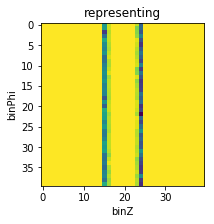

Volume: 12
Layer: 10


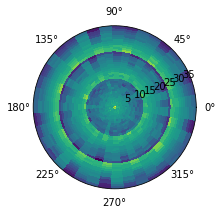

Layer: 12


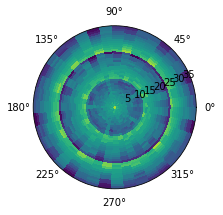

Layer: 2


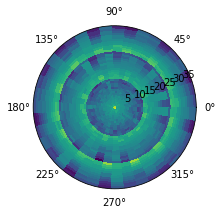

Layer: 4


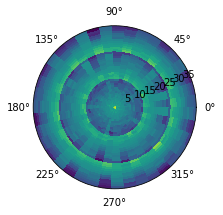

Layer: 6


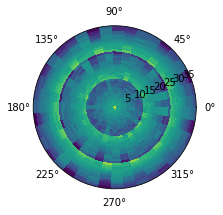

Layer: 8


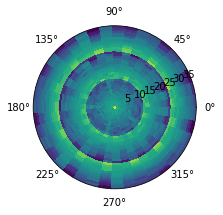

Volume: 13
Layer: 2


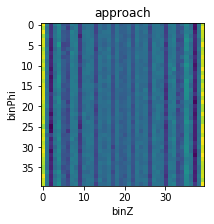

Layer: 4


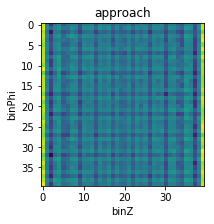

Layer: 6


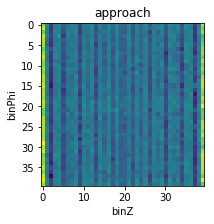

Layer: 8


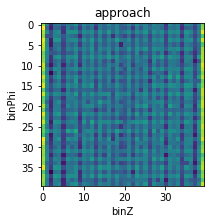

Volume: 14
Layer: 10


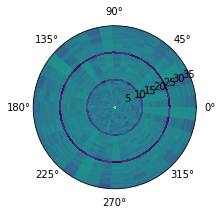

Layer: 12


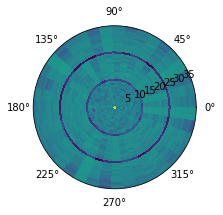

Layer: 2


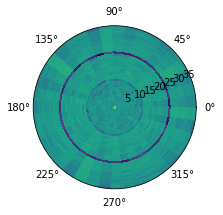

Layer: 4


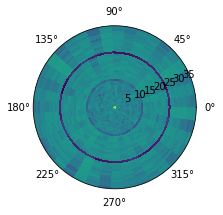

Layer: 6


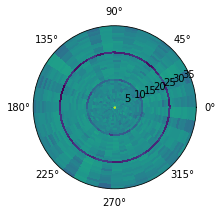

Layer: 8


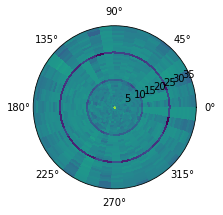

Volume: 16
Layer: 10


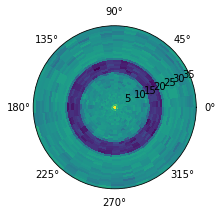

Layer: 12


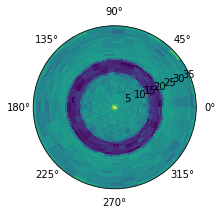

Layer: 2


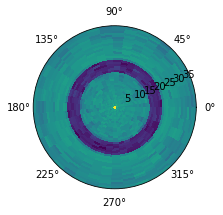

Layer: 4


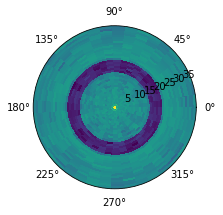

Layer: 6


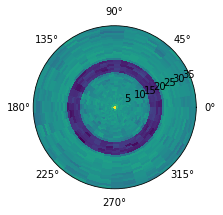

Layer: 8


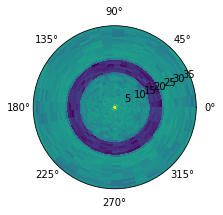

Volume: 17
Layer: 2


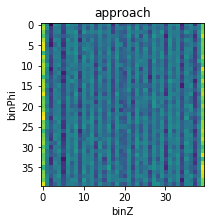

Layer: 4


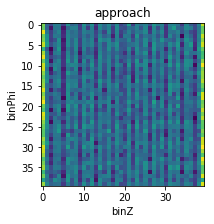

Volume: 18
Layer: 10


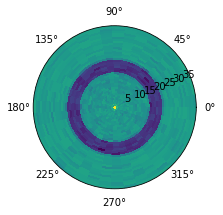

Layer: 12


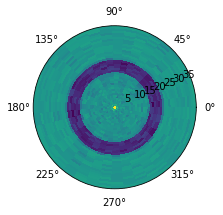

Layer: 2


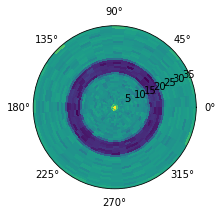

Layer: 4


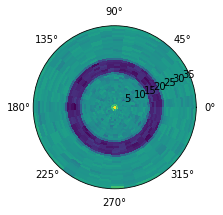

Layer: 6


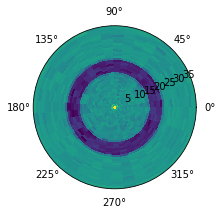

Layer: 8


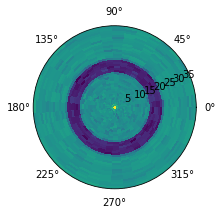

Volume: 5
Layer: 2


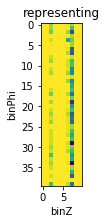

Volume: 7
Layer: 10


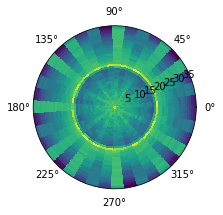

Layer: 12


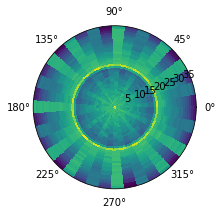

Layer: 14


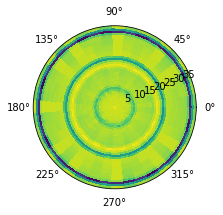

Layer: 2
Layer: 4
Layer: 6
Layer: 8


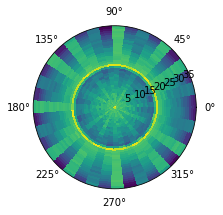

Volume: 8
Layer: 2


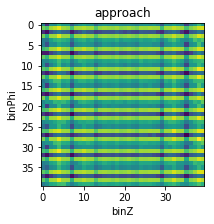

Layer: 4


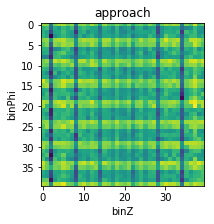

Layer: 6


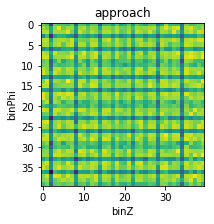

Layer: 8


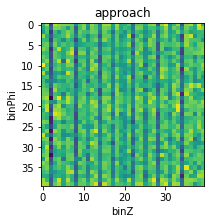

Volume: 9
Layer: 10
Layer: 12
Layer: 14
Layer: 2


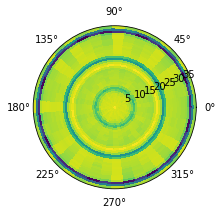

Layer: 4


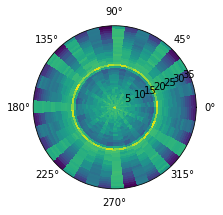

Layer: 6


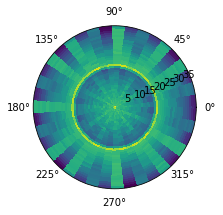

Layer: 8


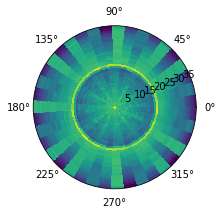

In [41]:
# curr_array = np.array(jc2[10][2]['representing'])

def layer_plot_prop(data, volume, layer, key=0):
#     print("Plotting for volume {}, layer {}".format(volume, layer))
    
    fig = plt.figure(figsize=(15,3))
    
    ss = data['volumes'][str(volume)]['layers'][str(layer)]
    
    if 'representing' in ss.keys():
        curr = []
        xvar = 'bin1'
        yvar = 'bin0'
        try:
            curr = list(filter(lambda x: not any([len(y)==0 for y in x]), ss['representing']['data']))
#             print(ss['representing']['data'])
            curr = np.array(curr)[:,:,key].T
            if ss['representing'][xvar][0] == 'binPhi':
                xvar, yvar = yvar, xvar
                curr = curr.T
            
            if ss['representing'][xvar][0] == 'binR':
                used_theta = np.linspace(0, 2*np.pi, curr.shape[0])
                used_rad = list(range(curr.shape[1]))
                X, Y = np.meshgrid(used_theta, used_rad)

                ax = fig.add_subplot(131, polar=True)
                ax.pcolormesh(X, Y, np.flip(curr.T, axis=0))
            else:
                plt.subplot(131)
                plt.imshow(curr)
                plt.title('representing')
                plt.xlabel(ss['representing'][xvar][0])
                plt.ylabel(ss['representing'][yvar][0])
            
        except:
            plt.close()
        
        
    if 'approach' in ss.keys():
        for sub in ss['approach']:
            curr = ss['approach'][sub]

            plt.subplot(131)
            plt.imshow(np.array(curr['data'])[:,:,key].T)
            plt.title('approach')
            plt.xlabel(curr['bin1'][0])
            plt.ylabel(curr['bin0'][0])
            
    plt.show()
        
    if len(set(ss.keys()) - {'approach', 'representing'}) > 0:
        raise Exception('Found a new type?!')
    
def volume_plot_prop(data, volume, key=0):
    for layer in data['volumes'][str(volume)]['layers']:
        print("Layer:",layer)
        layer_plot_prop(data, volume, layer, key)
        
def all_plot_prop(data, key=0):
    for volume in data['volumes']:
        print("Volume:",volume)
        volume_plot_prop(data, volume, key)
    
# layer_plot_prop(mapped_binned_proto, 10, 2, 1) # curr_array[:,:,3]
all_plot_prop(mapped_binned_proto_40, 1)

# layer_plot_prop(mapped_binned_proto_40, 5, 2, 1)

## Check that the number of surfaces is the same as that of those plotted using the PlyWriter tool in C++

In [43]:
num_layers = 0
for volume in mapped_binned_proto['volumes']:
        for layer in mapped_binned_proto['volumes'][str(volume)]['layers']:
            num_layers += 1
            
num_layers # should be same as "cat tempf.txt | grep Ply:\ Found\ surface\ material! | wc -l"

50

## Convenience tool to quickly generate a bin description file

In [25]:
def change_bins(d, v):
    try:
        for k in d.keys():
            if 'bin' in k:
                d[k][2] = v
            else:
                change_bins(d[k], v)
    except:
        pass
        
    return d

change_bins(proto_layer_mat, 40) # in place replace bins to 20 by 20
jss(proto_layer_mat, 'proto-layer-material-40.json')

./ACTFWGenericMaterialMappingExample -n 1000000  --mat-input-type file --mat-input-file proto-layer-material-N.json --mat-output-file mapped-binned-proto-N --output-json on --input-root on --input-files propagation-material-input.root -j1

# TODO: Setup feedback loop with bin configuration + cost function.

# TODO: Figure out cost function :: bin configuration -> score

## First cost function idea: (bin configuration) -> (bin per sensitive surface) 

# PROPER COST FUNCTION IDEA: sum of squared diffs between histogram bins

./ACTFWGenericMaterialValidationExample -n100 --mat-input-type file --mat-input-file mapped-binned-proto-20.json --output-root on

mv propagation-material.root propagation-material-test.root

## Initial analysis of possible cost functions (sum of squared differences)

In [44]:
file3 = uproot.open("propagation-material-input.root")

data_proto_binned = file3['material-tracks;14'].arrays(['*'])
# data_from_map = file2['material-tracks;2'].arrays(['*'])

# print(file1.keys(), file2.keys())
# file1['material-tracks;13'].show()
print(file3['material-tracks;14'].array('v_x').shape,file3['material-tracks;13'].array('v_x').shape)
# print(file2['material-tracks;2'].array('v_x').shape,file2['material-tracks;1'].array('v_x').shape)
# print("POSSIBLE ISSUE WITH -n100 in cmd3")
file3.keys()

(1000000,) (984191,)


[b'material-tracks;14', b'material-tracks;13']

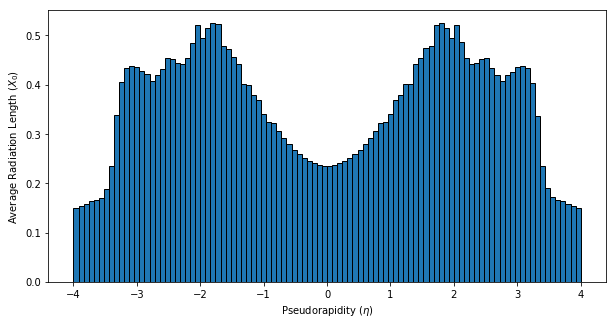

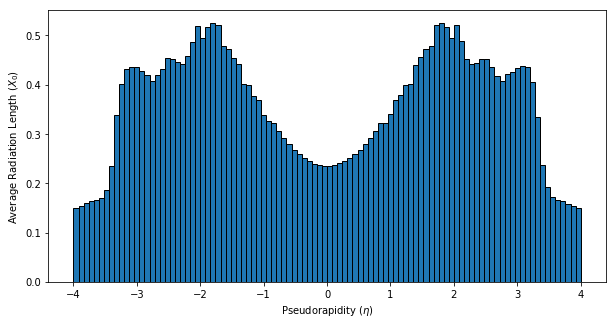

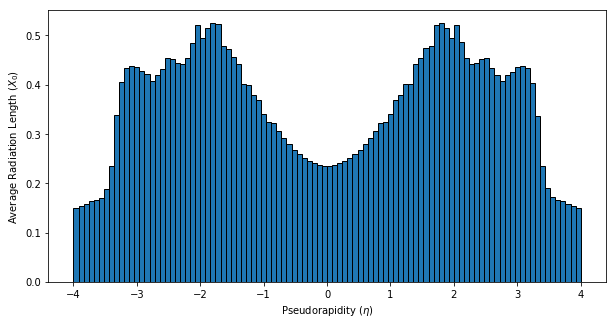

In [45]:
%matplotlib inline

h = stats.binned_statistic(data[b'v_eta'], data[b't_X0'], 'mean', bins=100)
h_centres = list(map(lambda x: sum(x)/2, zip(h.bin_edges[:-1],h.bin_edges[1:])))

plt.figure(figsize=(10,5))
plt.bar(h_centres, h.statistic, linewidth=1, edgecolor='k', width=0.08)
plt.xlabel(r"Pseudorapidity ($\eta$)")
plt.ylabel(r"Average Radiation Length ($X_0$)")
plt.show()

h = stats.binned_statistic(data_from_map[b'v_eta'], data_from_map[b't_X0'], 'mean', bins=100)
h_centres = list(map(lambda x: sum(x)/2, zip(h.bin_edges[:-1],h.bin_edges[1:])))

plt.figure(figsize=(10,5))
plt.bar(h_centres, h.statistic, linewidth=1, edgecolor='k', width=0.08)
plt.xlabel(r"Pseudorapidity ($\eta$)")
plt.ylabel(r"Average Radiation Length ($X_0$)")
plt.show()

h = stats.binned_statistic(data_proto_binned[b'v_eta'], data_proto_binned[b't_X0'], 'mean', bins=100)
h_centres = list(map(lambda x: sum(x)/2, zip(h.bin_edges[:-1],h.bin_edges[1:])))

plt.figure(figsize=(10,5))
plt.bar(h_centres, h.statistic, linewidth=1, edgecolor='k', width=0.08)
plt.xlabel(r"Pseudorapidity ($\eta$)")
plt.ylabel(r"Average Radiation Length ($X_0$)")
plt.show()

In [46]:
h1 = stats.binned_statistic(data[b'v_eta'], data[b't_X0'], 'mean', bins=100)
h2 = stats.binned_statistic(data_from_map[b'v_eta'], data_from_map[b't_X0'], 'mean', bins=100)
h3 = stats.binned_statistic(data_proto_binned[b'v_eta'], data_proto_binned[b't_X0'], 'mean', bins=100)

def ssd(y1, y2):
    return np.square(y1-y2).sum()

ssd(h1.statistic, h2.statistic), ssd(h2.statistic, h3.statistic), ssd(h1.statistic, h3.statistic)

(9.691239843483642e-05, 9.691239843483642e-05, 0.0)